# NEW VERSION

In [15]:
import os
import torch
from torch.utils.data import Dataset
from torchvision.io import read_image
from torchvision import transforms
from glob import glob
from collections import defaultdict
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import random_split, DataLoader


In [16]:
NUM_FRAMES = 16
ROOT_DIR = "../../data/hmdb51/videos"
SPLIT_DIR = "../../data/hmdb51/splits"
DATA_AUGMENTATION = True

In [17]:
class Hmdb51Dataset(Dataset):
    def __init__(self, root_dir, split_dir, split_id=1, split_type="train",
                 transform=None, num_frames=NUM_FRAMES,
                 selected_classes=None):  # <--- Nowy parametr
        self.root_dir = root_dir
        self.transform = transform
        self.num_frames = num_frames
        self.selected_classes = selected_classes  # <--- zapisz wybrane klasy
        self.samples = []
        self.class_to_idx = {}
        self.idx_to_class = {}
        self._load_split(split_dir, split_id, split_type)

    def _load_split(self, split_dir, split_id, split_type):
        if split_id not in [1, 2, 3]:
            print(f"Warning: Invalid split_id={split_id}. It should be 1, 2, or 3. No data will be loaded.")
            return
        if split_type not in ["train", "test"]:
            print(f"Warning: Invalid split_type='{split_type}'. It should be 'train' or 'test'. No data will be loaded.")
            return

        split_files = glob(os.path.join(split_dir, f"*_test_split{split_id}.txt"))

        # Filtrowanie klas
        if not self.class_to_idx:
            all_class_names = sorted([os.path.basename(f).split('_test_split')[0] for f in split_files])
            if self.selected_classes is not None:
                all_class_names = [c for c in all_class_names if c in self.selected_classes]
            self.class_to_idx = {name: i for i, name in enumerate(all_class_names)}
            self.idx_to_class = {i: name for name, i in self.class_to_idx.items()}

        for split_file in sorted(split_files):
            class_name = os.path.basename(split_file).split("_test_split")[0]

            if self.selected_classes is not None and class_name not in self.selected_classes:
                continue  # Pomijamy niechciane klasy

            label = self.class_to_idx[class_name]

            with open(split_file, "r") as f:
                for line in f:
                    if not line.strip(): continue
                    video_name, split_value = line.strip().split()
                    split_value = int(split_value)
                    target_split = 1 if split_type == "train" else 2
                    if split_value == target_split:
                        video_folder = os.path.join(self.root_dir, class_name, video_name.replace(".avi", ""))
                        if os.path.isdir(video_folder):
                            self.samples.append((video_folder, label))

        print(f"Loaded {len(self.samples)} samples for split '{split_type}' (split_id={split_id}). Total classes: {len(self.class_to_idx)}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        if idx >= len(self): raise IndexError("List index out of range.")
        folder_path, label = self.samples[idx]

        
        frame_paths = sorted(
            f for f in os.listdir(folder_path) 
            if f.lower().endswith(('.jpg', '.jpeg'))  # Case-insensitive
        )
        frame_paths = [os.path.join(folder_path, f) for f in frame_paths]

        # frame_paths = sorted(glob(os.path.join(folder_path, "*.jpg")))
        if len(frame_paths) == 0: raise ValueError(f"No frames found in: {folder_path}")
        if len(frame_paths) >= self.num_frames:
            indices = torch.linspace(0, len(frame_paths) - 1, self.num_frames).long()
        else:
            indices = torch.arange(len(frame_paths))
            indices = torch.cat([indices, torch.tensor([len(frame_paths)-1] * (self.num_frames - len(frame_paths)))])
        frames_list = [read_image(frame_paths[i]) for i in indices]
        frames = torch.stack(frames_list)
        if self.transform:
            frames = self.transform(frames)
        
        num_classes = len(self.class_to_idx)
        one_hot_label = torch.zeros(num_classes, dtype=torch.float32)
        one_hot_label[label] = 1.0
        
        return frames, one_hot_label

In [18]:
def imshow_grid(img_tensor, title, class_name, label_int):
    img_tensor = img_tensor.cpu().clone()
    grid_img = img_tensor.permute(1, 2, 0).numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    grid_img = std * grid_img + mean
    grid_img = np.clip(grid_img, 0, 1)
    plt.figure(figsize=(15, 10))
    plt.imshow(grid_img)
    plt.title(f"{title}\nKlasa: '{class_name}' (etykieta: {label_int})", fontsize=16)
    plt.axis('off')
    plt.show()

In [19]:
selected_actions = ["pullup", "pushup", "jump"]

transform = transforms.Compose([
    transforms.ConvertImageDtype(torch.float32),
    transforms.Resize((224, 224), antialias=True),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

if not os.path.isdir(ROOT_DIR):
    print(f"FATAL ERROR: Root directory not found at '{os.path.abspath(ROOT_DIR)}'.")
else:
    full_train_dataset = Hmdb51Dataset(
        root_dir=ROOT_DIR,
        split_dir=SPLIT_DIR,
        split_id=1,
        split_type="train",
        transform=transform,
        num_frames=NUM_FRAMES,
        selected_classes=selected_actions
    )

    print(ROOT_DIR)

    full_test_dataset = Hmdb51Dataset(
        root_dir=ROOT_DIR,
        split_dir=SPLIT_DIR,
        split_id=1,
        split_type="test",
        transform=transform,
        num_frames=NUM_FRAMES,
        selected_classes=selected_actions
    )

    print(len(full_test_dataset))

    generator = torch.Generator().manual_seed(42) 

    # Parametry
    TARGET_RATIO = 1  # Chcemy 10% danych

    # 1. Zmniejsz TRAIN do 10%
    train_size = int(TARGET_RATIO * len(full_train_dataset))
    dataset_train, _ = random_split(
        full_train_dataset,
        [train_size, len(full_train_dataset) - train_size],
        generator=generator
    )



    VALID_RATIO = 0.5
    valid_size = int(VALID_RATIO * len(full_test_dataset))
    dataset_valid, rest_to_test = random_split(
        full_test_dataset,
        [valid_size, len(full_test_dataset) - valid_size],
        generator=generator
    )

    test_size = int(TARGET_RATIO * len(rest_to_test))
    dataset_test, _ = random_split(
        rest_to_test,
        [test_size, len(rest_to_test) - test_size],
        generator=generator
    )

    # test_size = int(0.6 * len(full_test_dataset))
    # valid_size = len(full_test_dataset) - test_size
    
    # generator = torch.Generator().manual_seed(42) 
    
    # dataset_train, _ = random_split(full_train_dataset, [len(full_train_dataset), 0], generator=generator)


    # dataset_test, dataset_valid = random_split(full_test_dataset, [test_size, valid_size], generator=generator)

    print("\n--- Podsumowanie Datasetów ---")
    print(f"Zbiór treningowy:     {len(dataset_train)} próbek")
    print(f"Zbiór walidacyjny:   {len(dataset_valid)} próbek")
    print(f"Zbiór testowy:          {len(dataset_test)} próbek")

    train_loader = DataLoader(dataset_train, batch_size=8, shuffle=True)
    val_loader = DataLoader(dataset_valid, batch_size=8, shuffle=False)
    test_loader = DataLoader(dataset_test, batch_size=8, shuffle=False)

Loaded 209 samples for split 'train' (split_id=1). Total classes: 3
../../data/hmdb51/videos
Loaded 90 samples for split 'test' (split_id=1). Total classes: 3
90

--- Podsumowanie Datasetów ---
Zbiór treningowy:     209 próbek
Zbiór walidacyjny:   45 próbek
Zbiór testowy:          45 próbek



--- Weryfikacja nowej próbki ---
Kształt tensora klatek (X): torch.Size([16, 3, 224, 224])
Kształt etykiety one-hot (Y): torch.Size([3])
Fragment etykiety one-hot: tensor([1., 0., 0.])...
Odzyskana etykieta: 0, Klasa: jump


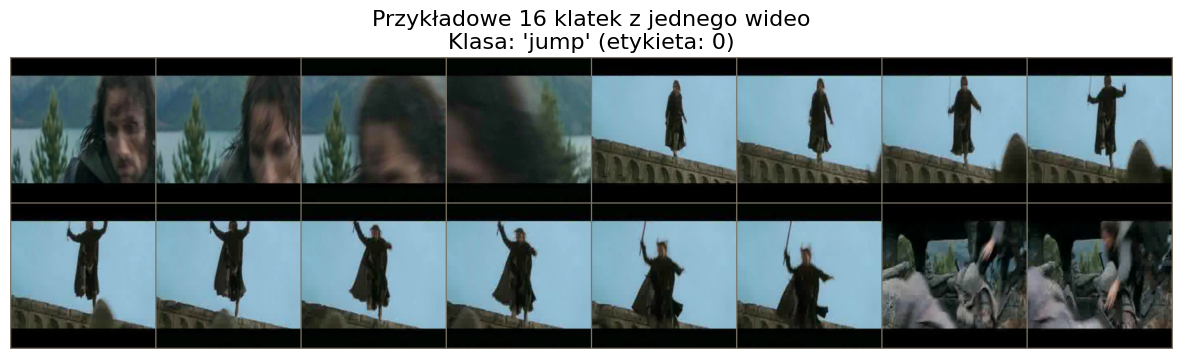

In [20]:
if len(dataset_train) > 0:
    print(f"\n--- Weryfikacja nowej próbki ---")
    
    frames, one_hot_label = dataset_train[7]
    
    print(f"Kształt tensora klatek (X): {frames.shape}")
    print(f"Kształt etykiety one-hot (Y): {one_hot_label.shape}")
    print(f"Fragment etykiety one-hot: {one_hot_label[:10]}...")
    
    label_int = torch.argmax(one_hot_label).item()
    class_name = dataset_train.dataset.idx_to_class[label_int]
    
    print(f"Odzyskana etykieta: {label_int}, Klasa: {class_name}")

    grid = torchvision.utils.make_grid(frames, nrow=8, padding=2)
    imshow_grid(grid, title="Przykładowe 16 klatek z jednego wideo", class_name=class_name, label_int=label_int)


In [21]:

if len(dataset_test) > 0:
    print(f"\n--- Weryfikacja nowej próbki ---")
    
    frames, one_hot_label = dataset_test[7]
    
    print(f"Kształt tensora klatek (X): {frames.shape}")
    print(f"Kształt etykiety one-hot (Y): {one_hot_label.shape}")
    print(f"Fragment etykiety one-hot: {one_hot_label[:10]}...")

    # Zakładamy, że dataset_test.dataset.class_to_idx istnieje
    # class_to_idx = dataset_test.dataset.class_to_idx
    # idx_to_class = {v: k for k, v in class_to_idx.items()}

    # label_int = torch.argmax(one_hot_label).item()
    # class_name = idx_to_class[label_int]
    # # label_int = torch.argmax(one_hot_label).item()
    # # class_name = dataset_test.dataset.idx_to_class[label_int]
    
    # print(f"Odzyskana etykieta: {label_int}, Klasa: {class_name}")

    # grid = torchvision.utils.make_grid(frames, nrow=8, padding=2)
    # imshow_grid(grid, title="Przykładowe 16 klatek z jednego wideo", class_name=class_name, label_int=label_int)



--- Weryfikacja nowej próbki ---
Kształt tensora klatek (X): torch.Size([16, 3, 224, 224])
Kształt etykiety one-hot (Y): torch.Size([3])
Fragment etykiety one-hot: tensor([0., 1., 0.])...
